9673


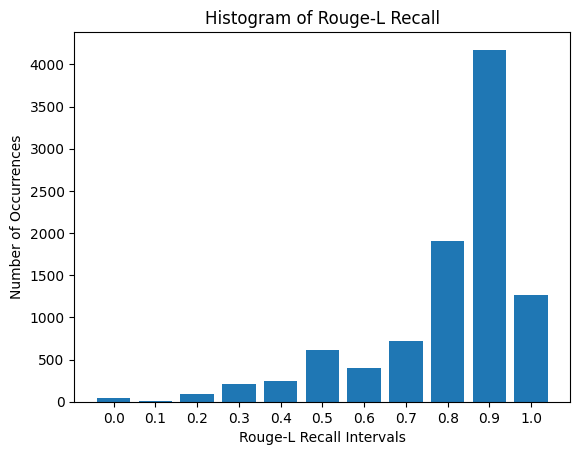

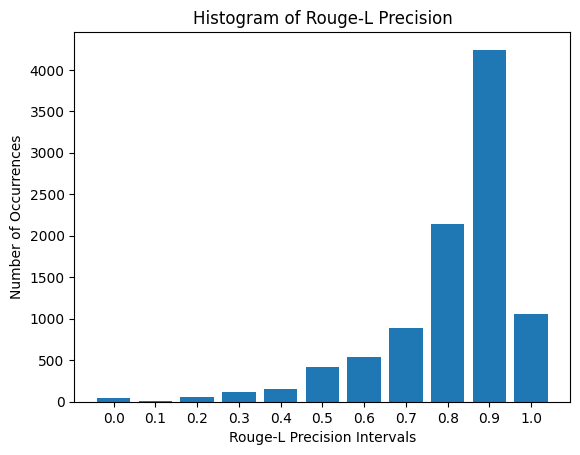

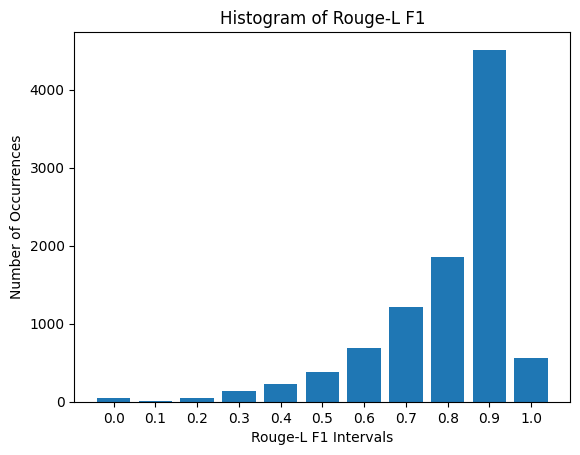

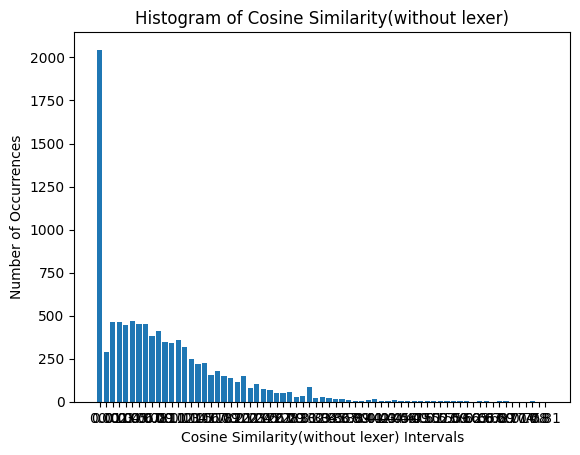

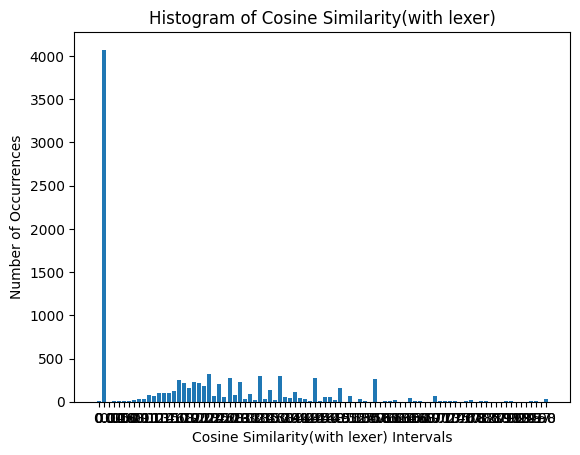

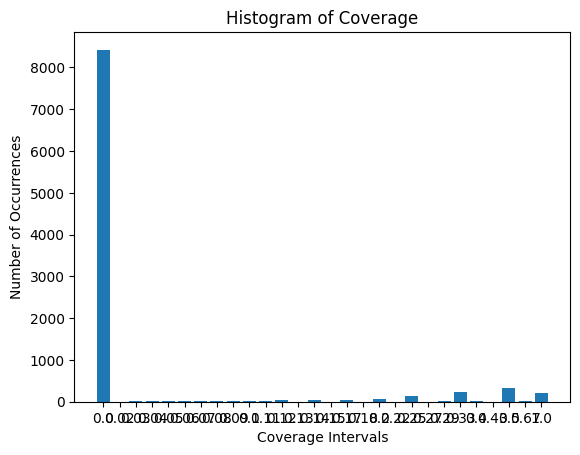

In [5]:
import math
from decimal import Decimal

from algo import calc_rouge_l, cal_cosine_similarity, get_identifier_set, get_token_str, calculate_coverage_ratio

import json
from collections import Counter
import matplotlib.pyplot as plt
import jsonlines

path = '../data/raw/test.jsonl'

# Replace 'your_metric_function' with your actual function to calculate the metric
def calculate_rouge(src_desc, dst_desc):
    return calc_rouge_l([dst_desc], src_desc)[0]
    

metrics = []

line_cnt = 0
with jsonlines.open(path) as reader:
    for parsed in reader:
        line_cnt += 1
        old_method = parsed['src_method']
        new_method = parsed['dst_method']
        src_desc = parsed['src_desc']
        dst_desc = parsed['dst_desc']
        # Calculate the metric and append to the list
        rouge_l = calculate_rouge(src_desc, dst_desc)
        d = rouge_l

        token_str = get_token_str(src_desc, dst_desc)
        
        similarity = cal_cosine_similarity(dst_desc, new_method)
        d = {**d, 'cs1': similarity}
        
        similarity = cal_cosine_similarity(dst_desc, token_str)
        d = {**d, 'cs2': similarity}
        
        s1 = get_identifier_set(new_method)
        s2 = get_identifier_set(old_method)
        s3 = s1 - s2
        ratio = calculate_coverage_ratio(s3, dst_desc)
        d = {**d, 'ratio': ratio}
        
        metrics.append(d)

print(line_cnt)

for m_key, m_name, m_preserve in (
        ('recall', 'Rouge-L Recall', 1),
        ('precision', 'Rouge-L Precision', 1),
        ('f1', 'Rouge-L F1', 1),
        ('cs1', 'Cosine Similarity(without lexer)', 2),
        ('cs2', 'Cosine Similarity(with lexer)', 2),
        ('ratio', 'Coverage', 2)
):
    # Count the occurrences of each metric interval
    metric_intervals = [str(round(metric[m_key], m_preserve)) for metric in metrics]  
    counts = Counter(metric_intervals)
    counts = dict(sorted(counts.items(), key=lambda item: item[0]))
    
    # Plotting the histogram
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(f'{m_name} Intervals')
    plt.ylabel("Number of Occurrences")
    plt.title(f'Histogram of {m_name}')
    plt.show()

